In [2]:
import numpy as np
import random
import time
import networkx as nx
from networkx.algorithms.approximation.independent_set import maximum_independent_set
import matplotlib.pyplot as plt
import matplotlib.colors as colorNames
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [3]:
def grafgen(M, colors, paint = True, labels = None):
    U = [ "{}".format(int(i+1)) for i in range(M.shape[0]) ]
    G = nx.DiGraph()
    G.add_edges_from([ (U[i], U[j]) for i, j in zip(*M.nonzero()) ])  
    cols = []
    for i in G.nodes():
        cols.append(colors[int(i)-1])
    if paint:
        if labels == None:
            labels = {node: int(node) - 1 for node in G.nodes()}
        else:
            labels = {node: labels[int(node) - 1] for node in G.nodes()}
        nx.draw(G, node_size = 900, node_color = cols, labels = labels)
    return G
    
def convertMatrixToList(mat):
    res = []
    for i in mat:
        res.append(np.where(i != 0)[0])
    return res

In [4]:
def graphIsFull(graph):
    fullGraph = np.ones((len(graph),len(graph))) - np.eye(len(graph))
    return np.array_equal(graph,fullGraph)

def p_zero(eigs):
    return len(np.where(eigs == 0)[0])

def p_neg(eigs):
    return len(np.where(eigs < 0)[0])

def p_pos(eigs):
    return len(np.where(eigs > 0)[0])

def chromaticNumberForFull(eigs):
    return len(eigs)/(p_zero(eigs) + min(p_neg(eigs),p_pos(eigs)))

In [5]:
def graphIsBipartite(eigs):
    res = True
    for x in eigs:
        res = (len(np.where(abs(eigs + x) < 0.000001)[0]) != 0)
        if not res:
            return res
    return res

In [6]:
def find_all_paths(mat, start_vertex, end_vertex, path=[], first=True):
    graph = convertMatrixToList(mat)
    path = path + [start_vertex]
    if start_vertex == end_vertex and not first:
        return [path]
    paths = []
    for vertex in graph[start_vertex]:
        if vertex not in path:
            extended_paths = find_all_paths(mat, vertex, end_vertex, path, False)
            for p in extended_paths: 
                paths.append(p)
    return paths

def findAllCycles(mat):
    cycles = []
    for i in range(len(mat)):
        for j in mat[i]:
            for cycle in find_all_paths(mat,i,j):
                if len(cycle) > 2:
                    cycle.append(i)
                    cycles.append(cycle) 
    return cycles

In [7]:
def graphIsRegular(eigs):
    r = round(sum(np.power(eigs, 2)), 7)
    return [round(r, 0) == r, r / len(eigs)]

def MNK(A: np.array, b: np.array) -> np.array:
    x = np.linalg.inv(A.T @ A) @ A.T @b
    return x

def charPol(mat, x):
    return np.linalg.det(mat - x * np.eye(len(mat)))

def powerOfPolInPol(coefsDivident, coefsDivisor):
    res = 0
    coefs = np.polydiv(coefsDivident, coefsDivisor)[0]
    rem = np.polydiv(coefsDivident, coefsDivisor)[1]
    while len(rem) > 1 or rem[0] > 0.00001:
        coefs = np.polydiv(coefs, coefsDivisor)[0]
        rem = np.polydiv(coefs, coefsDivisor)[1]
        res += 1
    return res    

def graphIsRegularWithSpecificR(mat):
    matForCoefDet = np.zeros((len(mat) + 1, len(mat) + 1))
    for i in range(len(mat) + 1):
        for j in range(len(mat) + 1):
            matForCoefDet[i,j] = i ** (len(mat) - j)

    vecForCoefDet = []
    for i in range(len(matForCoefDet)):
        vecForCoefDet.append(charPol(mat, i))
    
    coefsOfCharPol = MNK(matForCoefDet,vecForCoefDet)
    return round(0.5 * (len(mat) + powerOfPolInPol(coefsOfCharPol, [1, -2])\
                  - powerOfPolInPol(coefsOfCharPol, [1, 2]) + coefsOfCharPol[3]), 5)

In [8]:
def graphIsConnected(graph):
    graph = csr_matrix(graph)
    n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
    return n_components == 1

def p(x, eigs):
    return len(np.where(eigs == x))

def upperLimitForRegularAndConnected(eigs, r, n):
    return r + min(p(r - n, eigs), p(0, eigs) // (n - r - 1) + p(2, eigs) + p(-1, eigs) // -3) - (n - r) * p(r - n, eigs)

In [9]:
def upperLimitFromMax(eigs):
    return max(eigs) + 1

def upperLimitFromDims(graph):
    m = len(np.where(graph != 0)[0])
    return 1 + (2 * m * (1 - 1 / len(graph))) ** 0.5

def upperLimitFromEdges(graph):
    m = len(np.where(graph != 0)[0])
    return 0.5 + (2 * m + 0.25) ** 0.5

def lowerLimitFromMaxAndMin(eigs):
    return -1 * max(eigs) / min(eigs) + 1

def upperLimitFromHellerLemma(graph):
    m = len(np.where(graph != 0)[0])
    n = len(graph)
    if n ** 2 - 2 * m == 0:
        return 'Impossible to use Heller lemma!'
    return n ** 2 / (n ** 2 - 2 * m)

def lowerLimitFromIndex(r, n):
    return n / (n - r)

def graphIsEvenCycle(mat):
    cyclesLen = [(lambda i:len(i) - 1)(i) for i in findAllCycles(mat)]
    return max([num for num in cyclesLen if num % 2 == 1]) == len(mat)

def upperLimitFromBruxTheorema(mat):
    if graphIsFull(mat) or graphIsEvenCycle(mat):
        return max([(lambda i: len(i))(i) for i in convertMatrixToList(mat)]) + 1
    return max([(lambda i: len(i))(i) for i in convertMatrixToList(mat)])

def lowerLimitFromMaxIndSet(mat):
    return len(mat) / int(maximum_independent_set(grafgen(mat, suboptColors, False)).pop())

In [10]:
def chromaticNumber(mat):
    eigenvals = np.linalg.eig(mat)[0]
    if graphIsFull(mat):
        return chromaticNumberForFull(eigenvals)
    
    if graphIsBipartite(eigenvals):
        return 2
    
    if graphIsRegular(eigenvals)[0]:
        if graphIsRegular(eigenvals)[1] == len(mat) - 3 and graphIsConnected(mat):
            return graphIsRegularWithSpecificR(mat)

## Input Matrix:

In [10]:
#Take matrix size from first row input

firstRow = input().split(" ")
n = len(firstRow)

#initialise nxn matrix with zeroes
mat = np.zeros((n,n))

mat[0] = firstRow
#input each row at a time,with each element separated by a space
for i in range(1, n):
   mat[i] = input().split(" ")

print(mat) 

0 1 1 1 0 1
1 0 1 1 1 0
1 1 0 0 1 1
1 1 0 0 1 1
0 1 1 1 0 1
1 0 1 1 1 0
[[0. 1. 1. 1. 0. 1.]
 [1. 0. 1. 1. 1. 0.]
 [1. 1. 0. 0. 1. 1.]
 [1. 1. 0. 0. 1. 1.]
 [0. 1. 1. 1. 0. 1.]
 [1. 0. 1. 1. 1. 0.]]


# Graph Specter

In [11]:
eigenvectors = np.zeros((len(np.linalg.eig(mat)[1]),len(np.linalg.eig(mat)[1])))
for i in range(len(np.linalg.eig(mat)[1])):   
    eigenvectors[i] = np.linalg.eig(mat)[1][:,i]
    
eigenvalues = np.linalg.eig(mat)[0]
print('\033[1m'+'Given matrix has such eigenvalues and eigenvectors:'+'\033[0m')
print()

for i in range(len(np.linalg.eig(mat)[0])):
    print ('\033[1m'+'Eigenvalue:'+'\033[0m')
    print(eigenvalues[i])
    print ('\033[1m'+'Eigenvector:'+'\033[0m')
    print(eigenvectors[i])
    print()  

Given matrix has such eigenvalues and eigenvectors:

Eigenvalue:
3.999999999999998
Eigenvector:
[0.40824829 0.40824829 0.40824829 0.40824829 0.40824829 0.40824829]

Eigenvalue:
-2.0
Eigenvector:
[ 0.57735027 -0.28867513 -0.28867513 -0.28867513  0.57735027 -0.28867513]

Eigenvalue:
2.3670935836458137e-16
Eigenvector:
[ 2.86911039e-03  7.07100960e-01 -3.52215907e-17  4.84949275e-17
 -2.86911039e-03 -7.07100960e-01]

Eigenvalue:
-9.725444256624274e-17
Eigenvector:
[-5.83004557e-01  4.00132086e-01  3.66553474e-17 -7.76343068e-18
  5.83004557e-01 -4.00132086e-01]

Eigenvalue:
-2.0
Eigenvector:
[ 0.11324116 -0.54690859  0.43366743  0.43366743  0.11324116 -0.54690859]

Eigenvalue:
0.0
Eigenvector:
[-6.09831730e-17  3.40922237e-16 -7.07106781e-01  7.07106781e-01
  7.44524369e-17 -3.30083010e-16]



## Exact Chromatic Number:

In [12]:
print('Exact Chromatic Number:')
print(chromaticNumber(mat))
print()

Exact Chromatic Number:
None



In [13]:
def timeit(f, *args):
    start = time.time()
    res = f(*args)
    end = time.time()
    delta = end - start if end - start != 0 else 'less than 10^-16'
    if end - start == 0:
        print()
    print(f'This function took {delta} seconds to execute.')
    return f'Limit is {res}'

## Graph coloring:


In [11]:
## Построить правильную вершинную раскраску графа.
## \param graph -- граф в виде массива множеств номеров смежных вершин
## \param forbidden -- массив множеств запрещённых цветов для каждой вершины
## \param color -- массив цветов вершин
## \return массив (новых) цветов вершин
def coloring(mat, forbidden=None, color=None):
    graph = convertMatrixToList(mat)
    if forbidden is None: forbidden = []
    if color is None: color = []
    # Предусловия.
    assert len(forbidden) == 0 or len(forbidden) == len(graph)
    assert len(color) == 0 or len(color) == len(graph)
 
    if len(forbidden) == 0:
        forbidden = [frozenset()]*len(graph)
    # Раскраска в два цвета поиском в глубину.
    def coloring2():
        color2 = [0]*len(graph)
        def dfsColoring2(u, c=1):
            if color2[u] == 0:
                for d in range(c, len(graph)+1):
                    if d not in forbidden[u]:
                        color2[u] = d
                        break
                c = 3 - c
                for v in graph[u]:
                    dfsColoring2(v, c)

        for start in range(0, len(graph)):
            dfsColoring2(start)
        return color2

    # Построить начальную раскраску, если требуется.
    if len(color) == 0:
        color = coloring2()
    # Перечислить текущие конфликты цветов.
    def listConflicts():
        conflicts = []
        for u in range(0, len(graph)):
            nc = [color[v] for v in graph[u]]
            conflict_rank = nc.count(color[u])
            if conflict_rank > 0:
                nc = frozenset(nc) | forbidden[u]
                new_color = max(nc) + 1
                for c in range(1, new_color-1):
                    if c not in nc:
                        new_color = c
                        break
                conflict = (conflict_rank, new_color, u)
                conflicts.append(conflict)
        conflicts.sort(
            key=lambda c: (c[0], -c[1], c[2]), reverse=True)
        return conflicts

    # Разрешить конфликты цветов (потенциально не все).
    def resolveConflicts(conflicts):
        closed = set()
        for _, new_color, u in conflicts:
            if u in closed:
                continue
            color[u] = new_color
            closed |= set(graph[u])

    # Собственно алгоритм: начиная с некоторой раскраски,
    # повторять обнаружение и разрешение конфликтов, 
    # пока список конфликтов не опустеет.
    interrupt = 0
    while True:
        conflicts = listConflicts()
        prevLen = len(conflicts)
        if len(conflicts) == 0:
            return color
        resolveConflicts(conflicts)
        if prevLen == len(conflicts):
            interrupt += 1
        if interrupt == 100:
            return color

# Optimal Graph Coloring

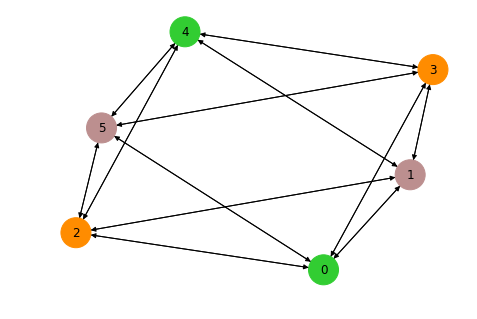

In [38]:
suboptColorsNumbers = coloring(mat)
suboptColors = []
COLORS = []
for name, hex in colorNames.cnames.items():
    COLORS.append(name)
random.shuffle(COLORS)   
for i in suboptColorsNumbers:
    suboptColors.append(COLORS[i])
    
grafgen(mat, suboptColors)

## Chromatic Number Limits From Different Theorems:

In [16]:
print('\033[1m'+'Upper Limits:'+'\033[0m')
print()
print('Upper Limit From Maximum Of Eigenvalues:')
print(timeit(upperLimitFromMax, eigenvalues))
print()

print('Upper Limit From Dimensions:')
print(timeit(upperLimitFromDims, mat))
print()

if graphIsConnected(mat):
    print('Upper Limit From Edges Quantity:')
    print(timeit(upperLimitFromEdges, mat))
    print()

if len(eigenvalues) - graphIsRegular(eigenvalues)[1] % 2 == 0 and graphIsConnected(mat):
    print('Upper Limit For Regular And Connected Graph With Odd n - r:')
    print(timeit(upperLimitForRegularAndConnected,eigenvalues, graphIsRegular(eigenvalues)[1], len(eigenvalues)))
    print()
    
print('Upper Limit From Brux Theorema:')
print(timeit(upperLimitFromBruxTheorema,mat))
print()   

print('Upper Limit From Heller Lemma:')
print(timeit(upperLimitFromHellerLemma,mat))
print()

print('\033[1m'+'Lower Limits:'+'\033[0m')
print()

print('Lower Limit From Maximum And Minimum Of Eigenvalues:')
print(timeit(lowerLimitFromMaxAndMin,eigenvalues))
print()

if graphIsRegular(eigenvalues)[0]:
    print('Lower Limit From Regularity Index')
    print(timeit(lowerLimitFromIndex,graphIsRegular(eigenvalues)[1], len(mat)))
    print()
    
print('Lower Limit From Maximum Independent Set Size:')
print(timeit(lowerLimitFromMaxIndSet,mat))
print()

Upper Limits:

Upper Limit From Maximum Of Eigenvalues:

This function took less than 10^-16 seconds to execute.
Limit is 4.999999999999998

Upper Limit From Dimensions:

This function took less than 10^-16 seconds to execute.
Limit is 7.324555320336759

Upper Limit From Edges Quantity:

This function took less than 10^-16 seconds to execute.
Limit is 7.446221994724902

Upper Limit From Brux Theorema:
This function took 0.06285810470581055 seconds to execute.
Limit is 4

Upper Limit From Heller Lemma:

This function took less than 10^-16 seconds to execute.
Limit is -3.0

Lower Limits:

Lower Limit From Maximum And Minimum Of Eigenvalues:

This function took less than 10^-16 seconds to execute.
Limit is 2.999999999999999

Lower Limit From Regularity Index

This function took less than 10^-16 seconds to execute.
Limit is 3.0

Lower Limit From Maximum Independent Set Size:
This function took 0.0009732246398925781 seconds to execute.
Limit is 2.0



# Sceduling

## Input scheduling matrix:

In [13]:
print('Input schedule names:')
scheduleNames = input().split(", ")
print()

print('Input matrix:')
#Take matrix size from first row input
firstRow = input().split(" ")
n = len(firstRow)

#initialise nxn matrix with zeroes
schedule = np.zeros((n,n))

schedule[0] = firstRow
#input each row at a time,with each element separated by a space
for i in range(1, n):
   schedule[i] = input().split(" ")

print(schedule) 

Input schedule names:
Сисан, Матан, Линейная алгебра, Физика, Теория управления, Нейронные сети

Input matrix:
0 1 1 0 0 1
1 0 1 0 1 0
1 1 0 1 0 0
0 0 1 0 1 1
0 1 0 1 0 1
1 0 0 1 1 0
[[0. 1. 1. 0. 0. 1.]
 [1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1.]
 [0. 1. 0. 1. 0. 1.]
 [1. 0. 0. 1. 1. 0.]]


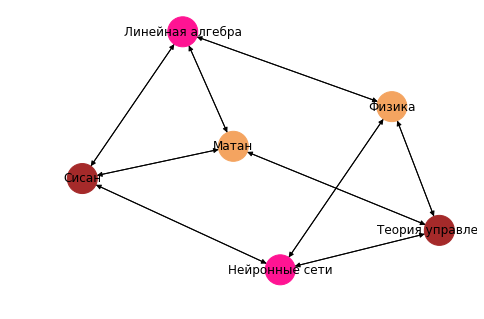

In [17]:
suboptColorsNumbersForSchedule = coloring(schedule)
suboptColorsForSchedule = []
COLORS = []
for name, hex in colorNames.cnames.items():
    COLORS.append(name)
random.shuffle(COLORS)   
for i in suboptColorsNumbersForSchedule:
    suboptColorsForSchedule.append(COLORS[i])
optimalSchedule = []
for i in range(max(suboptColorsNumbersForSchedule)):
    optimalSchedule.append([])
for i in range(len(scheduleNames)):
    optimalSchedule[suboptColorsNumbersForSchedule[i] - 1].append(scheduleNames[i])

grafgen(schedule, suboptColorsForSchedule, labels = scheduleNames)    

# Optimal Schedule:

In [18]:
optimalSchedule

[['Сисан', 'Теория управления'],
 ['Матан', 'Физика'],
 ['Линейная алгебра', 'Нейронные сети']]